https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.false_discovery_control.html

# TODO: 

- look to see if anyone has perfected method for correlating gene expression against a phenotype/trait at single cell scale.
- REPEAT PROCESS FOR GEP 22, SEND CSVS TO HOJUN. make pandas code cleaner/reusable. incorporate correction for zero inflation?
- calculate p values for each correlation (HSC, gene, GEP vs progenitor, gene, GEP). basically same thing as task 1, but separate HSCs and progenitor.
- make CDFs color coded. add to dataframe boolean columns whether the correlations are significant or not. use the scipy correlation correction thing above

In [46]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

In [2]:
def read_metadata():
    return pd.read_csv('./data/metadata.csv').rename(columns={'Unnamed: 0': 'cell'}).set_index('cell')

def read_full_counts():
    adata = sc.read_h5ad("./data/hultcd34_full.h5ad")
    adata.obs = metadata
    df = adata.to_df()
    return df.merge(metadata, left_index=True, right_index=True)

# account for cells thrown out in cell-GEP dataframe, also keep only HSCs and progenitors
def filter_full_counts(df):
    cell_GEP_mapping = read_cell_GEP()
    gep_set = set(cell_GEP_mapping.index)
    raw_counts_set = set(df.index)
    difference = raw_counts_set.difference(gep_set)
    
    df = df[~df.index.isin(difference)]
    df = (df
          [(df['cluster'] != 'Uncommitted') | (df['subcluster'] == 'HSC')]
          .iloc[:, :-9]
         )
    
    return df

def read_cell_GEP():
    cell_GEP_mapping = pd.read_csv(r'./data/Factorized matrices from human lifetime scRNA(GEP usage per cell).csv').set_index('Cell')
    return cell_GEP_mapping.merge(metadata, left_index=True, right_index=True)
    
# keep only HSCs and progenitors
def filter_cell_GEP(cell_GEP_mapping):
    cell_GEP_mapping = (cell_GEP_mapping
                    [(cell_GEP_mapping['cluster'] != 'Uncommitted') | (cell_GEP_mapping['subcluster'] == 'HSC')]
                    .iloc[:, :35]
                   )
    return cell_GEP_mapping

In [21]:
target_GEP = 'GEP 15 (DNA Replication)'
# target_GEP = 'GEP 22 (Cell cycle)'

metadata = read_metadata()
df = (read_full_counts()
      .pipe(filter_full_counts)
     )
cell_GEP_mapping = (read_cell_GEP()
                    .pipe(filter_cell_GEP)
                   )

task 1 -

look at HSCs and progenitors together. plot gene exp (x) vs GEP 15 output (y). do some regression hypothesis testing and use multiple testing correction (Bonferoni correction)

In [39]:
def calculate_p_regression(row):
    X = row
    y = cell_GEP_mapping[target_GEP]
    
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    p_value = model.pvalues.iloc[1]
    
    all_res[row.name] = p_value
    
def dict_to_df_p(res):
    df = pd.DataFrame.from_dict(res, orient='index', columns=['p-value'])
    df.index.name = 'gene'
    return df

In [41]:
all_res = {}
df.apply(calculate_p_regression)
all_cell_p = dict_to_df_p(all_res)

In [42]:
all_cell_p

,p-value
gene,
X5S-rRNA,8.526727e-02
X5-8S-rRNA,1.738760e-01
X7SK,5.589672e-02
A1BG,1.022608e-03
A1BG.AS1,1.298155e-02
...,...
snoZ278,8.610352e-01
snoZ40,8.981182e-01
snoZ6,2.091348e-01


task 2 -

for each gene:

separate HSCs and progenitors.

calculate 2 r values (one for HSCs only and other progenitors only) for gene expression (df cols) to predict GEP 15

compare abs difference in r

In [24]:
def get_merged(df, cell_GEP_mapping):
    target = cell_GEP_mapping[[target_GEP]]
    df = (df
          .merge(target, left_index=True, right_index=True)
          .merge(metadata, left_index=True, right_index=True)
          )
    return df

def get_HSC(merged):
    hsc = merged[merged['subcluster'] == 'HSC'].iloc[:, :-9]
    hsc_X = hsc.iloc[:, :-1]
    hsc_y = hsc[target_GEP]
    return hsc_X, hsc_y

def get_prog(merged):
    prog = merged[merged['cluster'] != 'Uncommitted'].iloc[:, :-9]
    prog_X = prog.iloc[:, :-1]
    prog_y = prog[target_GEP]
    return prog_X, prog_y

In [37]:
merged = get_merged(df, cell_GEP_mapping)
hsc_X, hsc_y = get_HSC(merged)
prog_X, prog_y = get_prog(merged)

In [69]:
def get_stats_hsc(col):
    X = col
    y = hsc_y
    r, p_val = pearsonr(X, y)
    hsc_res.append({'gene': col.name, 'r hsc': r, 'p hsc': p_val})

def get_stats_prog(col):
    X = col
    y = prog_y
    r, p_val = pearsonr(X, y)
    prog_res.append({'gene': col.name, 'r prog': r, 'p prog': p_val})

In [71]:
hsc_res = []
hsc_X.apply(get_stats_hsc)
hsc_df = pd.DataFrame(hsc_res).set_index('gene')

prog_res = []
prog_X.apply(get_stats_prog)
prog_df = pd.DataFrame(prog_res).set_index('gene')

/scratch/sbhayani/job_38547160/ipykernel_1686258/3174154782.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p_val = pearsonr(X, y)
/scratch/sbhayani/job_38547160/ipykernel_1686258/3174154782.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p_val = pearsonr(X, y)


In [73]:
res = hsc_df.merge(prog_df, left_index=True, right_index=True)
res

,r hsc,p hsc,r prog,p prog
gene,,,,
X5S-rRNA,-0.015419,1.427281e-01,-0.010093,7.045731e-02
X5-8S-rRNA,-0.015324,1.452079e-01,-0.005839,2.952979e-01
X7SK,-0.019402,6.511455e-02,-0.009996,7.320596e-02
A1BG,-0.021253,4.333934e-02,-0.017721,1.491988e-03
A1BG.AS1,-0.010456,3.202510e-01,-0.015464,5.577552e-03
...,...,...,...,...
snoZ278,0.006918,5.107836e-01,-0.002881,6.055565e-01
snoZ40,0.008128,4.397728e-01,-0.003055,5.840565e-01
snoZ6,-0.005762,5.839209e-01,-0.007821,1.610173e-01


In [28]:
# res.to_csv(f'correlations/GEP_{target_GEP[4:6]}_correlation.csv', index=True)

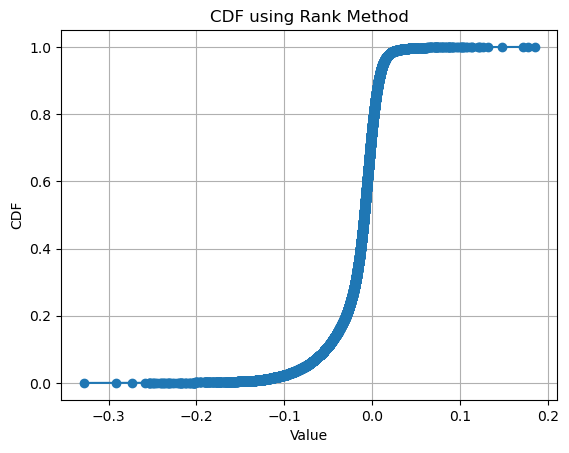

In [31]:
def plot_cdf(s):
    cdf = s.rank(method='average', pct=True)
    sorted_s = s.sort_values()

    plt.plot(sorted_s.values, cdf[sorted_s.index], marker='o', linestyle='-')
    plt.xlabel('Value')
    plt.ylabel('CDF')
    plt.title('CDF using Rank Method')
    plt.grid(True)
    plt.show()